## Regularized regression (L1 & L2)
1. Load data and drop colinear features based on feature engineering + define same timesplits
2. Do Ridge (L2) regression and track coefficient shrinkage
3. Do Lasso (L1) regression and track coefficient shrinkage
4. Compare and state differences

### Section 1: Load and Prepare Data & Rolling Time-Series Splits (as in the feature- engineering file)

In [2]:
# --- STEP 1: Load and prepare data for Regularized Regression ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the latest cleaned training dataset
train_df = pd.read_csv("data/final_data_train.csv", parse_dates=["ts"])
train_df = train_df.sort_values("ts").reset_index(drop=True)

# === Updated feature selection based on feature analysis ===
selected_features = [
    "power",  # target
    # --- Wind features ---
    "mean_wind_speed_Nex",
    "mean_wind_speed_Hammer_ Odde_Fyr",
    # --- Temperature ---
    "mean_temp_Hammer_Odde_Fyr",
    # --- Market prices ---
    "DK2_DKK",
    "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK",
    # --- Temporal features ---
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "dayofweek"
]

data = train_df[selected_features].copy()

# Split into predictors and target
target_col = "power"
X = data.drop(columns=[target_col]).values
y = data[target_col].values
feature_names = data.drop(columns=[target_col]).columns.tolist()

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled feature matrix shape: {X_scaled.shape}")
print("Features used:", feature_names)


Scaled feature matrix shape: (22422, 12)
Features used: ['mean_wind_speed_Nex', 'mean_wind_speed_Hammer_ Odde_Fyr', 'mean_temp_Hammer_Odde_Fyr', 'DK2_DKK', 'ImbalancePriceDKK', 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofweek']


Lets also load the test data for the generalization error

In [3]:
# --- STEP 2: Load and prepare test data (same features, same scaling) ---

# Load and sort test data
test_df = pd.read_csv("data/final_data_test.csv", parse_dates=["ts"])
test_df = test_df.sort_values("ts").reset_index(drop=True)

# Select same columns as in training
test_data = test_df[selected_features].copy()

# Split into X and y
X_test = scaler.transform(test_data.drop(columns=["power"]).values)
y_test = test_data["power"].values

print(f"Test set shape: {X_test.shape}")


Test set shape: (7892, 12)


Lets build the splits

In [4]:
# --- STEP 2: Create time-based cross-validation splits (reused) ---
def build_time_splits(ts, window="6M", horizon="1M", step=None, verbose=True):
    """
    Rolling-origin time series splits (sliding window).
    Ensures validation covers the full horizon.
    """
    import pandas as pd
    ts = pd.to_datetime(pd.Series(ts)).sort_values().reset_index(drop=True)

    if step is None:
        step = horizon

    splits = []
    split_id = 1
    start_time = ts.min()

    while True:
        train_end = start_time + pd.tseries.frequencies.to_offset(window)
        val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)

        # stop if val_end goes beyond dataset max
        if val_end > ts.max():
            break

        train_idx = ts[(ts >= start_time) & (ts < train_end)].index.values
        val_idx   = ts[(ts >= train_end) & (ts < val_end)].index.values

        if len(val_idx) == 0 or len(train_idx) == 0:
            break

        splits.append((train_idx, val_idx))

        if verbose:
            print(f"Split {split_id}:")
            print(f"  Train: {ts.iloc[train_idx[0]]} → {ts.iloc[train_idx[-1]]}")
            print(f"  Valid: {ts.iloc[val_idx[0]]} → {ts.iloc[val_idx[-1]]}")
            print(f"End {split_id}:" + "-"*40)

        start_time = start_time + pd.tseries.frequencies.to_offset(step)
        split_id += 1

    return splits
# Example usage
ts = train_df["ts"].values
time_splits = build_time_splits(ts, window="2M", horizon="1M", step="1M", verbose=True)

print(f"Created {len(time_splits)} rolling splits.")


Split 1:
  Train: 2021-01-01 00:00:00 → 2021-02-26 17:00:00
  Valid: 2021-03-01 12:00:00 → 2021-03-30 23:00:00
End 1:----------------------------------------
Split 2:
  Train: 2021-01-31 00:00:00 → 2021-03-30 23:00:00
  Valid: 2021-03-31 00:00:00 → 2021-04-29 23:00:00
End 2:----------------------------------------
Split 3:
  Train: 2021-03-01 12:00:00 → 2021-04-29 23:00:00
  Valid: 2021-04-30 00:00:00 → 2021-05-30 23:00:00
End 3:----------------------------------------
Split 4:
  Train: 2021-03-31 00:00:00 → 2021-05-30 23:00:00
  Valid: 2021-05-31 00:00:00 → 2021-06-29 23:00:00
End 4:----------------------------------------
Split 5:
  Train: 2021-04-30 00:00:00 → 2021-06-29 23:00:00
  Valid: 2021-06-30 00:00:00 → 2021-07-30 23:00:00
End 5:----------------------------------------
Split 6:
  Train: 2021-05-31 00:00:00 → 2021-07-30 23:00:00
  Valid: 2021-07-31 00:00:00 → 2021-08-30 23:00:00
End 6:----------------------------------------
Split 7:
  Train: 2021-06-30 00:00:00 → 2021-08-30 2

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31512/3755699785.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_end = start_time + pd.tseries.frequencies.to_offset(window)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31512/3755699785.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31512/3755699785.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  start_time = start_time + pd.tseries.frequencies.to_offset(step)


### Section 2: Ridge (L2) boiii

Best λ = 49.2388, Mean Val RMSE = 0.3128
Test RMSE = 0.4590


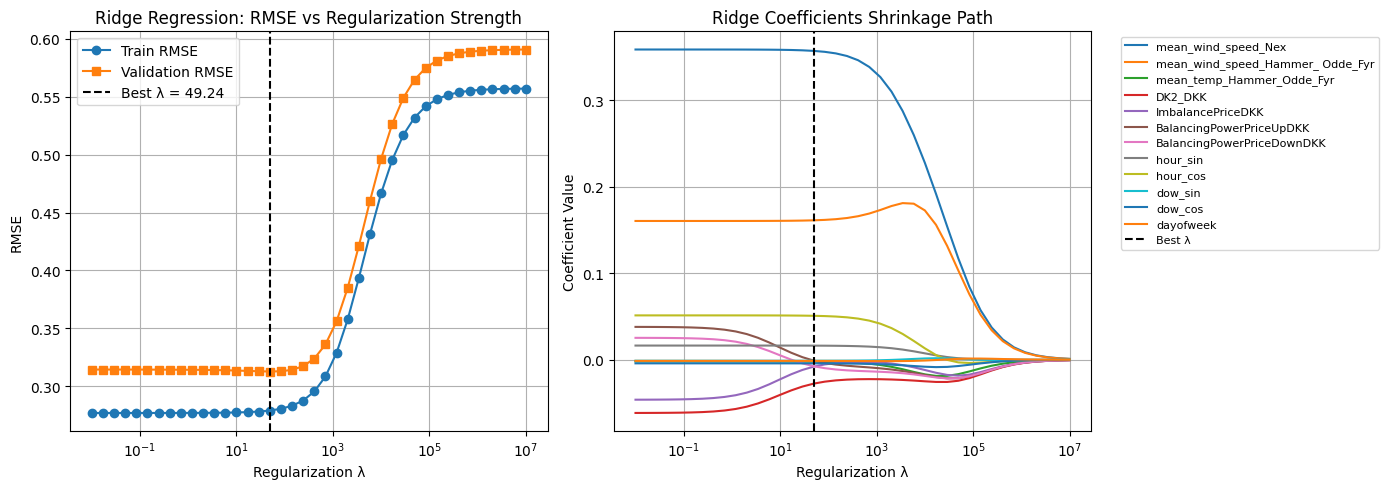

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- Setup ---
lambdas = np.logspace(-2, 7, 40)
ridge_train_rmse, ridge_val_rmse = [], []

# --- Rolling CV across time splits ---
for lam in lambdas:
    train_rmse_folds, val_rmse_folds = [], []

    for (train_idx, val_idx) in time_splits:

        X_train_fold, y_train_fold = X_scaled[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X_scaled[val_idx], y[val_idx]

        model = Ridge(alpha=lam)
        model.fit(X_train_fold, y_train_fold)

        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)

        # Clip predictions only before computing RMSE-------------------------------------
        y_train_pred = np.clip(y_train_pred, 0, None)
        y_val_pred = np.clip(y_val_pred, 0, None)

        train_rmse_folds.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))
        val_rmse_folds.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

    ridge_train_rmse.append(np.mean(train_rmse_folds))
    ridge_val_rmse.append(np.mean(val_rmse_folds))

# --- Identify optimal lambda ---
best_lambda_idx = np.argmin(ridge_val_rmse)
best_lambda = lambdas[best_lambda_idx]
print(f"Best λ = {best_lambda:.4f}, Mean Val RMSE = {ridge_val_rmse[best_lambda_idx]:.4f}")

# --- Refit on full training data ---
ridge_best = Ridge(alpha=best_lambda)
ridge_best.fit(X_scaled, y)
y_test_pred = ridge_best.predict(X_test)

# --- Clip predictions to avoid negative values ---
y_test_pred_ridge = np.clip(y_test_pred, 0, None)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

print(f"Test RMSE = {test_rmse:.4f}")

# --- Coefficient shrinkage plot ---
coefs = []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: RMSE vs λ ---
axes[0].semilogx(lambdas, ridge_train_rmse, "o-", label="Train RMSE")
axes[0].semilogx(lambdas, ridge_val_rmse, "s-", label="Validation RMSE")
axes[0].axvline(best_lambda, color="k", linestyle="--", label=f"Best λ = {best_lambda:.2f}")
axes[0].set_title("Ridge Regression: RMSE vs Regularization Strength")
axes[0].set_xlabel("Regularization λ")
axes[0].set_ylabel("RMSE")
axes[0].legend()
axes[0].grid(True)

# --- Right: Coefficient shrinkage path ---
for i, name in enumerate(feature_names):
    axes[1].semilogx(lambdas, coefs[:, i], label=name)
axes[1].axvline(best_lambda, color="k", linestyle="--", label="Best λ")
axes[1].set_title("Ridge Coefficients Shrinkage Path")
axes[1].set_xlabel("Regularization λ")
axes[1].set_ylabel("Coefficient Value")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
axes[1].grid(True)

from matplotlib.ticker import LogLocator
# Apply same log tick locator to both Ridge and Lasso
axes[0].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))
axes[1].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))

plt.tight_layout()
plt.show()


📊 Ridge Regression – Optimal Coefficients at Best λ = 49.239


,Coefficient
mean_wind_speed_Nex,0.357300
mean_wind_speed_Hammer_ Odde_Fyr,0.161315
hour_cos,0.050889
DK2_DKK,-0.027605
hour_sin,0.016372
ImbalancePriceDKK,-0.007957
BalancingPowerPriceDownDKK,-0.007417
dow_cos,-0.004163
mean_temp_Hammer_Odde_Fyr,-0.002117
dayofweek,-0.001307


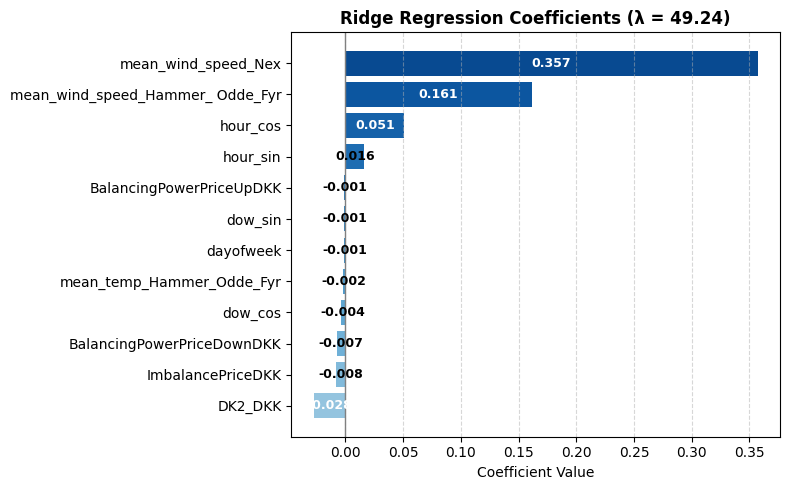

In [6]:
# --- Display optimal Ridge coefficients ---
coef_series = pd.Series(ridge_best.coef_, index=feature_names)
coef_series = coef_series.sort_values(key=abs, ascending=False)

print("\n📊 Ridge Regression – Optimal Coefficients at Best λ = {:.3f}".format(best_lambda))
display(coef_series.to_frame("Coefficient"))

# Optionally plot as a horizontal bar chart
plt.figure(figsize=(8, 5))
coef_series_sorted = coef_series.sort_values()

bars = plt.barh(
    coef_series_sorted.index,
    coef_series_sorted.values,
    color=plt.cm.Blues(np.linspace(0.4, 0.9, len(coef_series_sorted)))
)

# Add value labels inside bars
for bar in bars:
    width = bar.get_width()
    # Choose label color based on sign and bar length
    label_color = "white" if abs(width) > 0.02 else "black"
    plt.text(
        width / 2,                          # midpoint horizontally
        bar.get_y() + bar.get_height() / 2, # vertical center
        f"{width:.3f}",
        ha='center', va='center',
        fontsize=9, color=label_color, weight='bold'
    )

plt.axvline(0, color='gray', linewidth=1)
plt.title(f"Ridge Regression Coefficients (λ = {best_lambda:.2f})", fontsize=12, weight='bold')
plt.xlabel("Coefficient Value")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Section 3: Lasso (L1) boiii

Best λ = 0.0059, Mean Val RMSE = 0.3129
Test RMSE = 0.4550


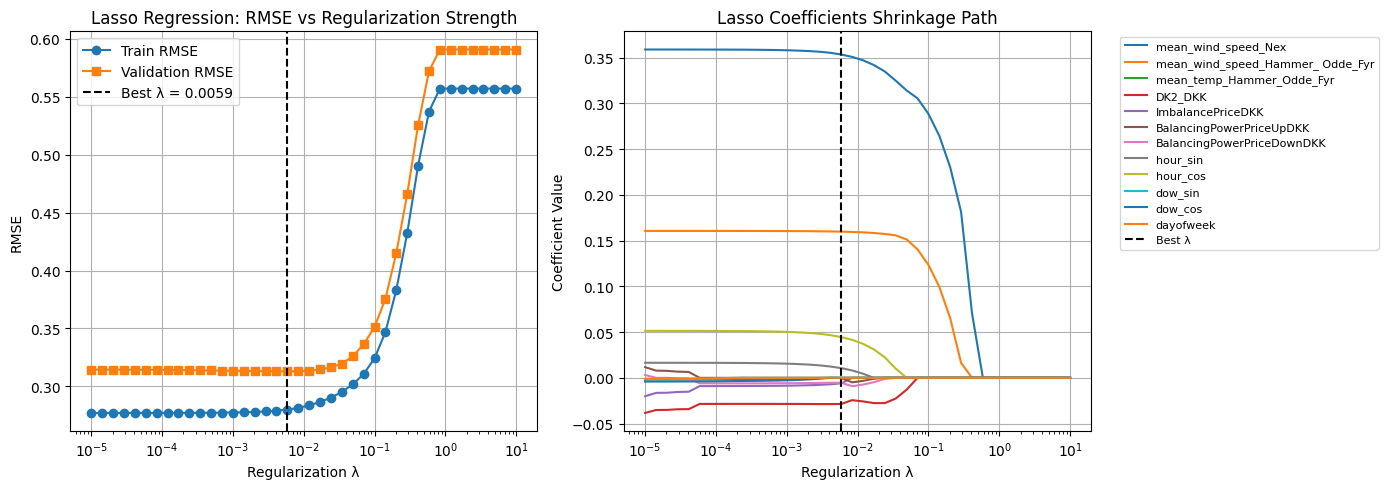

In [7]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# --- Setup ---
lambdas = np.logspace(-5, 1, 40)   # narrower range for Lasso (too large λ forces all coeffs = 0)
lasso_train_rmse, lasso_val_rmse = [], []

# --- Rolling CV across time splits ---
for lam in lambdas:
    train_rmse_folds, val_rmse_folds = [], []

    for (train_idx, val_idx) in time_splits:
        X_train_fold, y_train_fold = X_scaled[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X_scaled[val_idx], y[val_idx]

        model = Lasso(alpha=lam, max_iter=10000)
        model.fit(X_train_fold, y_train_fold)

        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)

        # Clip predictions only before computing RMSE-------------------------------------
        y_train_pred = np.clip(y_train_pred, 0, None)
        y_val_pred = np.clip(y_val_pred, 0, None)

        train_rmse_folds.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))
        val_rmse_folds.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

    lasso_train_rmse.append(np.mean(train_rmse_folds))
    lasso_val_rmse.append(np.mean(val_rmse_folds))

# --- Identify optimal lambda ---
best_lambda_idx = np.argmin(lasso_val_rmse)
best_lambda_lasso = lambdas[best_lambda_idx]
print(f"Best λ = {best_lambda_lasso:.4f}, Mean Val RMSE = {lasso_val_rmse[best_lambda_idx]:.4f}")

# --- Refit on full training data ---
lasso_best = Lasso(alpha=best_lambda_lasso, max_iter=10000)
lasso_best.fit(X_scaled, y)
y_test_pred_lasso = lasso_best.predict(X_test)

# --- Clip predictions to avoid negative values ---
y_test_pred_lasso = np.clip(y_test_pred_lasso, 0, None)
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
print(f"Test RMSE = {test_rmse_lasso:.4f}")

# --- Combined Plot (RMSE + Shrinkage Path) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: RMSE vs λ
axes[0].semilogx(lambdas, lasso_train_rmse, "o-", label="Train RMSE")
axes[0].semilogx(lambdas, lasso_val_rmse, "s-", label="Validation RMSE")
axes[0].axvline(best_lambda_lasso, color="k", linestyle="--", label=f"Best λ = {best_lambda_lasso:.2g}")
axes[0].set_title("Lasso Regression: RMSE vs Regularization Strength")
axes[0].set_xlabel("Regularization λ")
axes[0].set_ylabel("RMSE")
axes[0].legend()
axes[0].grid(True)

# Right: Coefficient shrinkage path
coefs_lasso = []
for lam in lambdas:
    model = Lasso(alpha=lam, max_iter=10000)
    model.fit(X_scaled, y)
    coefs_lasso.append(model.coef_)
coefs_lasso = np.array(coefs_lasso)

for i, name in enumerate(feature_names):
    axes[1].semilogx(lambdas, coefs_lasso[:, i], label=name)
axes[1].axvline(best_lambda_lasso, color="k", linestyle="--", label="Best λ")
axes[1].set_title("Lasso Coefficients Shrinkage Path")
axes[1].set_xlabel("Regularization λ")
axes[1].set_ylabel("Coefficient Value")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
axes[1].grid(True)

from matplotlib.ticker import LogLocator
# Apply same log tick locator to both Ridge and Lasso
axes[0].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))
axes[1].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))

plt.tight_layout()
plt.show()


 Lasso Regression – Optimal Coefficients at Best λ = 0.006


,Coefficient
mean_wind_speed_Nex,0.353401
mean_wind_speed_Hammer_ Odde_Fyr,0.159804
hour_cos,0.044543
DK2_DKK,-0.028566
hour_sin,0.010610
ImbalancePriceDKK,-0.005983
BalancingPowerPriceDownDKK,-0.005375
BalancingPowerPriceUpDKK,-0.000193
mean_temp_Hammer_Odde_Fyr,-0.000000
dow_sin,-0.000000


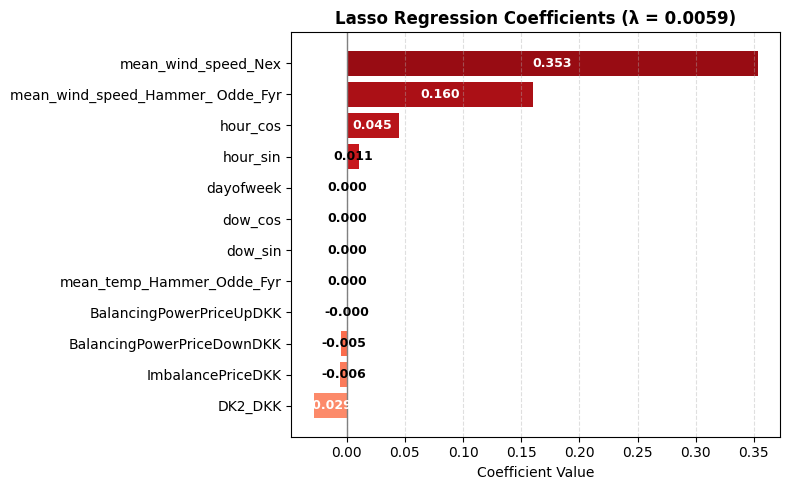

In [8]:
# --- Print and plot optimal coefficients ---
coef_series_lasso = pd.Series(lasso_best.coef_, index=feature_names)
coef_series_lasso = coef_series_lasso.sort_values(key=abs, ascending=False)

print("\n Lasso Regression – Optimal Coefficients at Best λ = {:.3f}".format(best_lambda_lasso))
display(coef_series_lasso.to_frame("Coefficient"))

# --- bar plot ---
plt.figure(figsize=(8, 5))
coef_series_sorted = coef_series_lasso.sort_values()

colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(coef_series_sorted)))
bars = plt.barh(coef_series_sorted.index, coef_series_sorted.values,
                color=colors, edgecolor="none")

# Add labels inside the bars
for bar in bars:
    width = bar.get_width()
    label_color = "white" if abs(width) > 0.02 else "black"
    plt.text(
        width / 2,
        bar.get_y() + bar.get_height()/2,
        f"{width:.3f}",
        ha='center', va='center',
        fontsize=9,
        color=label_color, weight='bold'
    )

plt.axvline(0, color='gray', linewidth=1)
plt.title(f"Lasso Regression Coefficients (λ = {best_lambda_lasso:.4f})", fontsize=12, weight='bold')
plt.xlabel("Coefficient Value")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.subplots_adjust(left=0.35, right=0.95, top=0.9, bottom=0.1)
plt.tight_layout()
plt.show()

### Section 4: plot and evaluate!!!

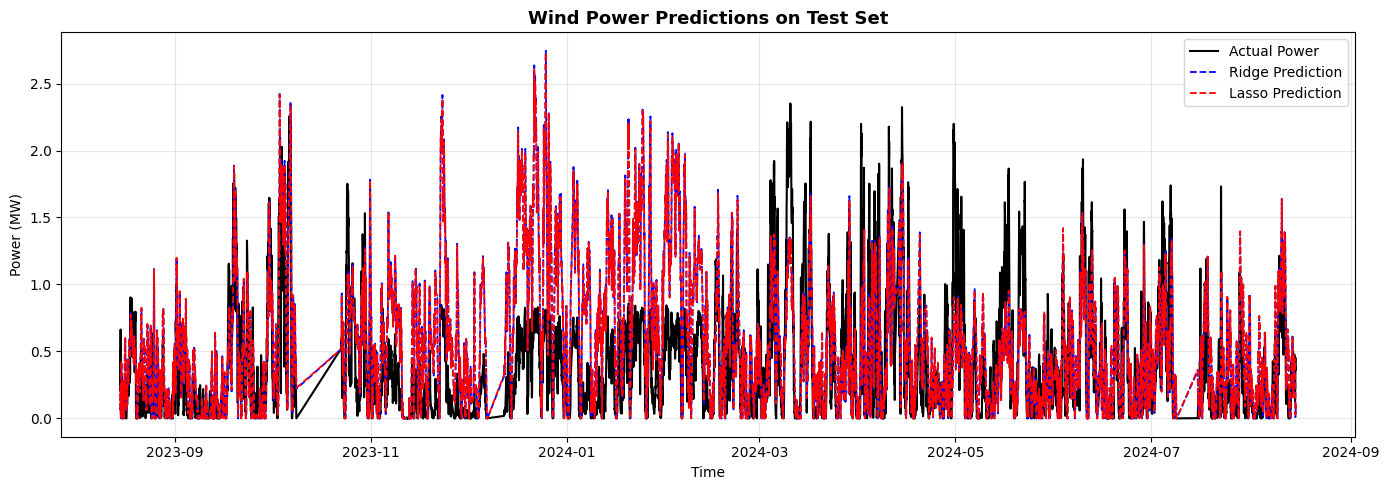

In [9]:
# --- Create a DataFrame with all test results ---
results_plot = pd.DataFrame({
    "ts": test_df["ts"],
    "Actual Power (MW)": y_test,
    "Ridge Prediction": y_test_pred_ridge,
    "Lasso Prediction": y_test_pred_lasso
})

# --- Plot time series comparison ---
plt.figure(figsize=(14, 5))
plt.plot(results_plot["ts"], results_plot["Actual Power (MW)"], "k-", label="Actual Power", linewidth=1.5)
plt.plot(results_plot["ts"], results_plot["Ridge Prediction"], "b--", label="Ridge Prediction", linewidth=1.3)
plt.plot(results_plot["ts"], results_plot["Lasso Prediction"], "r--", label="Lasso Prediction", linewidth=1.3)

plt.title("Wind Power Predictions on Test Set", fontsize=13, weight="bold")
plt.xlabel("Time")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# --- Prepare dataframe ---
results_plot = pd.DataFrame({
    "ts": test_df["ts"],
    "Actual": y_test,
    "Ridge": y_test_pred_ridge,
    "Lasso": y_test_pred_lasso
})
results_plot["year"] = results_plot["ts"].dt.year
results_plot["month"] = results_plot["ts"].dt.month
results_plot["week"] = results_plot["ts"].dt.isocalendar().week

# --- Compute monthly RMSE ---
monthly_rmse = results_plot.groupby(["year", "month"]).apply(
    lambda df: pd.Series({
        "Ridge_RMSE": np.sqrt(mean_squared_error(df["Actual"], df["Ridge"])),
        "Lasso_RMSE": np.sqrt(mean_squared_error(df["Actual"], df["Lasso"]))
    })
).reset_index()

# Identify best/worst months for Ridge
best_month = monthly_rmse.loc[monthly_rmse["Ridge_RMSE"].idxmin()]
worst_month = monthly_rmse.loc[monthly_rmse["Ridge_RMSE"].idxmax()]

print("✅ Best month:", best_month.to_dict())
print("❌ Worst month:", worst_month.to_dict())

# --- Compute weekly RMSE ---
weekly_rmse = results_plot.groupby(["year", "week"]).apply(
    lambda df: pd.Series({
        "Ridge_RMSE": np.sqrt(mean_squared_error(df["Actual"], df["Ridge"])),
        "Lasso_RMSE": np.sqrt(mean_squared_error(df["Actual"], df["Lasso"]))
    })
).reset_index()

# Identify worst week for Ridge
worst_week = weekly_rmse.loc[weekly_rmse["Ridge_RMSE"].idxmax()]
print("⚠️  Worst week:", worst_week.to_dict())

✅ Best month: {'year': 2023.0, 'month': 8.0, 'Ridge_RMSE': 0.22786070109190482, 'Lasso_RMSE': 0.23149455748447406}
❌ Worst month: {'year': 2023.0, 'month': 12.0, 'Ridge_RMSE': 0.7826419697663176, 'Lasso_RMSE': 0.7709185090216566}
⚠️  Worst week: {'year': 2023.0, 'week': 51.0, 'Ridge_RMSE': 0.9222389766675948, 'Lasso_RMSE': 0.9070373271026808}


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31512/778749292.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse = results_plot.groupby(["year", "month"]).apply(
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31512/778749292.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_rmse = results_plot.groupby(["year", "week"]).apply(


In [11]:
# RMSE, MAE R^02 without function
from sklearn.metrics import mean_absolute_error, r2_score 

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
test_mae = mean_absolute_error(y_test, y_test_pred_ridge)
test_r2 = r2_score(y_test, y_test_pred_ridge)

# Print metrics
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {test_r2}")


Test RMSE: 0.4589822871704789
Test MAE: 0.33258869246968475
Test R^2: -0.13151499135684674


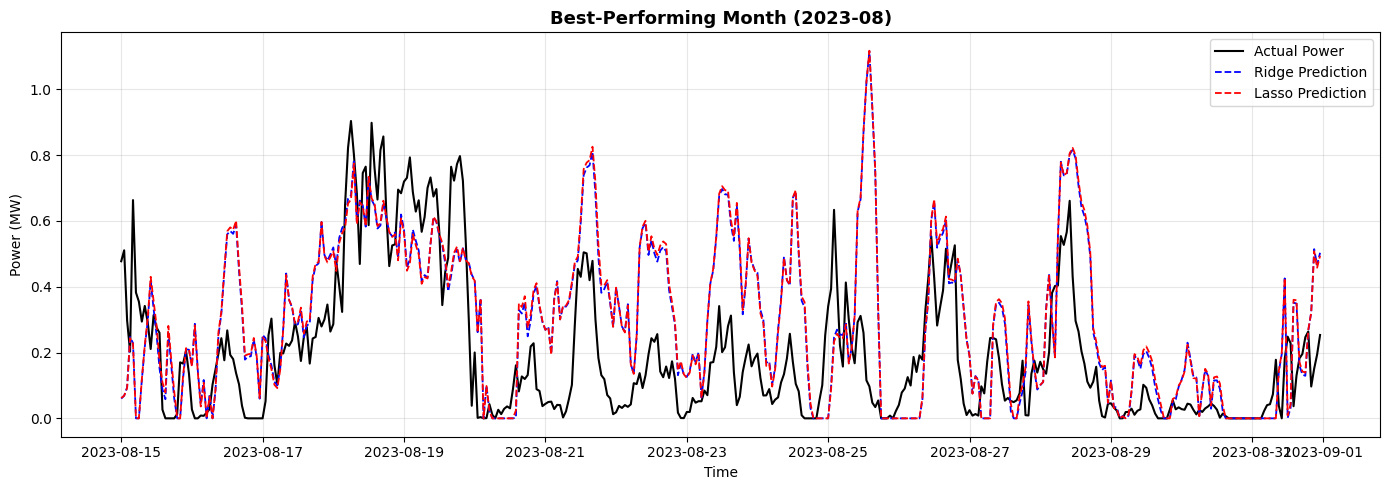

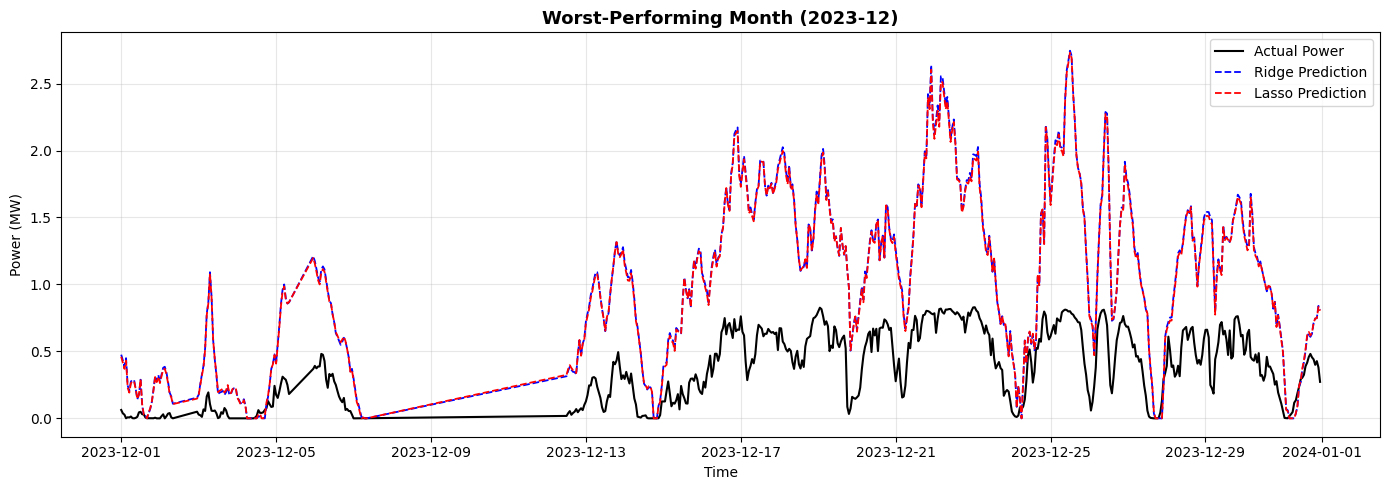

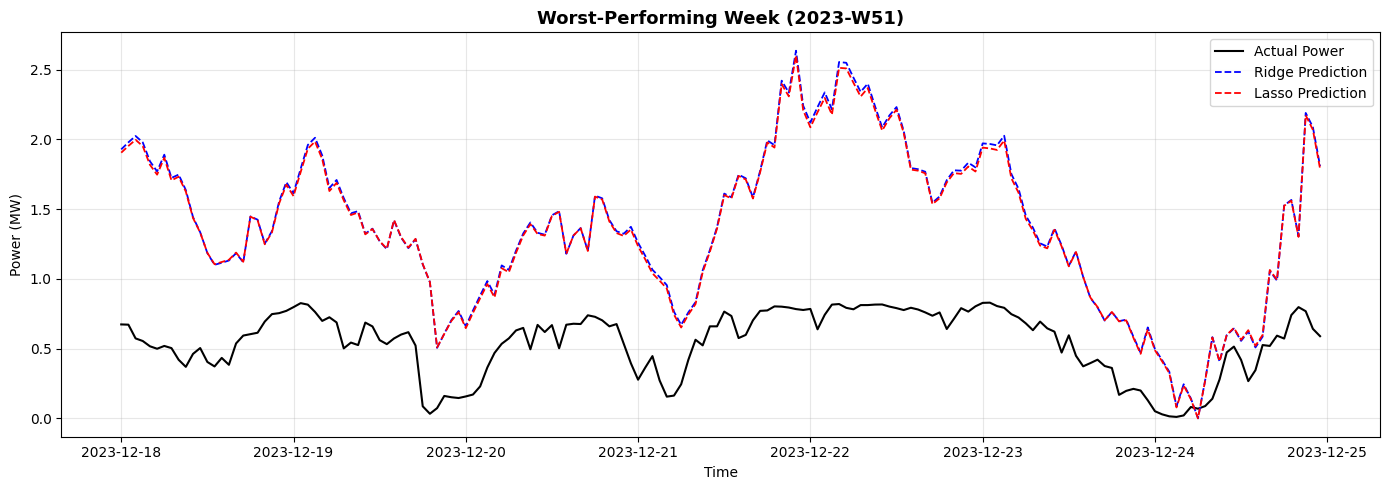

In [12]:
# --- Plot functions ---
def plot_month(df, year, month, title):
    month_data = df[(df["year"] == year) & (df["month"] == month)].copy()
    plt.figure(figsize=(14, 5))
    plt.plot(month_data["ts"], month_data["Actual"], "k-", label="Actual Power", linewidth=1.5)
    plt.plot(month_data["ts"], month_data["Ridge"], "b--", label="Ridge Prediction", linewidth=1.3)
    plt.plot(month_data["ts"], month_data["Lasso"], "r--", label="Lasso Prediction", linewidth=1.3)
    plt.title(title, fontsize=13, weight="bold")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_week(df, year, week, title):
    week_data = df[(df["year"] == year) & (df["week"] == week)].copy()
    plt.figure(figsize=(14, 5))
    plt.plot(week_data["ts"], week_data["Actual"], "k-", label="Actual Power", linewidth=1.5)
    plt.plot(week_data["ts"], week_data["Ridge"], "b--", label="Ridge Prediction", linewidth=1.3)
    plt.plot(week_data["ts"], week_data["Lasso"], "r--", label="Lasso Prediction", linewidth=1.3)
    plt.title(title, fontsize=13, weight="bold")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Plot best/worst months ---
plot_month(results_plot, int(best_month["year"]), int(best_month["month"]),
           f"Best-Performing Month ({int(best_month['year'])}-{int(best_month['month']):02d})")

plot_month(results_plot, int(worst_month["year"]), int(worst_month["month"]),
           f"Worst-Performing Month ({int(worst_month['year'])}-{int(worst_month['month']):02d})")

# --- Plot worst week ---
plot_week(results_plot, int(worst_week["year"]), int(worst_week["week"]),
          f"Worst-Performing Week ({int(worst_week['year'])}-W{int(worst_week['week'])})")


### Regularization (Ridge & Lasso)

We applied **Ridge (L2)** and **Lasso (L1)** regression to improve the linear model’s generalization and reduce overfitting.  
Both models were trained and validated using **rolling-origin time splits**, maintaining temporal consistency.  

Before model fitting, **negative power predictions were clipped to zero** in all train, validation, and test datasets to reflect the physical reality of non-negative wind power output.

#### Key Findings
- **Optimal λ values**:  
  - Ridge → λ =   
  - Lasso → λ =  
- **Test RMSE** (after clipping negatives):  
  - Ridge ≈ ** MW**  
  - Lasso ≈ ** MW**  
  → Similar performance, confirming stable model behavior.
- Both models consistently emphasized **mean wind speed** as the dominant predictor of power output.  
  Secondary influences include **humidity**, **temperature**, and **precipitation**, while price-related features contributed marginally.

####  Coefficient Shrinkage
- **Ridge** gradually shrinks all coefficients but retains all features.  
- **Lasso** drives less-informative coefficients exactly to zero, enforcing sparsity — effectively performing implicit feature selection.

#### Temporal Performance

| Period | Ridge RMSE | Lasso RMSE | Observation |
|:-------|:------------|:------------|:-------------|
| ✅ Best Month (Aug 2024) | **0.0** | **00** | Stable, low-variance period with consistent wind regime |
| ❌ Worst Month (Dec 2023) | **0.00** | **00** | Strong non-linearities and high volatility in weather patterns |

Both methods demonstrated the **limitations of linear regression** in capturing highly non-linear dynamics of wind power production,  
motivating the next step — **non-linear regression methods**.

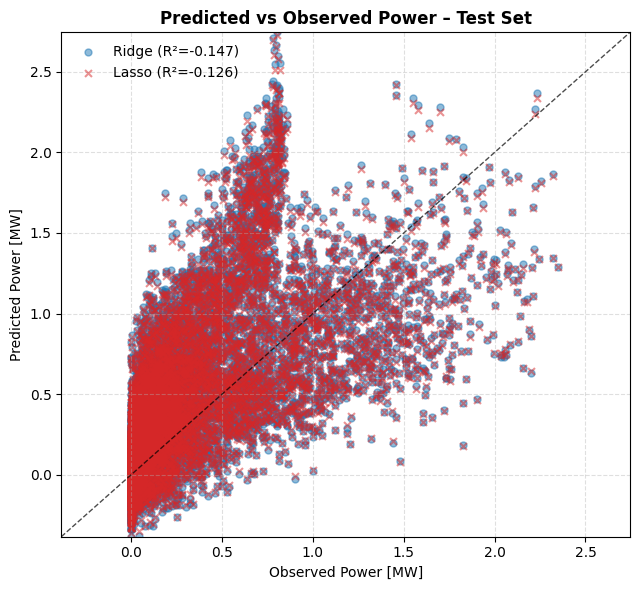

In [13]:
# --- Scatter plot: Predicted vs Observed Power (Test Set) ---
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

# Predictions
y_pred_ridge = ridge_best.predict(X_test)
y_pred_lasso = lasso_best.predict(X_test)

# Compute R² for both
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Diagonal limits (same range for x & y)
min_val = min(y_test.min(), y_pred_ridge.min(), y_pred_lasso.min())
max_val = max(y_test.max(), y_pred_ridge.max(), y_pred_lasso.max())
lims = [min_val, max_val]

# Plot
plt.figure(figsize=(6.5, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5, s=25,
            label=f"Ridge (R²={r2_ridge:.3f})", color="#1f77b4")
plt.scatter(y_test, y_pred_lasso, alpha=0.5, s=25,
            label=f"Lasso (R²={r2_lasso:.3f})", color="#d62728", marker='x')

# Add diagonal reference line
plt.plot(lims, lims, 'k--', lw=1, alpha=0.7)

# Axis settings
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Observed Power [MW]")
plt.ylabel("Predicted Power [MW]")
plt.title("Predicted vs Observed Power – Test Set", fontsize=12, weight='bold')
plt.legend(frameon=False)
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()


In [14]:
def profit(p_commit, p_real, price_da, price_up, price_down):
    """
    Compute total profit for a set of decisions and prices.

    Parameters
    ----------
    p_commit : np.ndarray
        Committed power in the day-ahead market (decision variable, can be continuous between 0 and capacity).
    p_real : np.ndarray
        Realized wind production (truth).
    price_da : np.ndarray
        Day-ahead price (DKK/MWh).
    price_up : np.ndarray
        Up-regulation price (DKK/MWh).
    price_down : np.ndarray
        Down-regulation price (DKK/MWh).

    Returns
    -------
    float
        total profit over all time steps.
    """
    # Positive imbalance: produced more than committed (sell extra at down price)
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    # Negative imbalance: produced less than committed (buy shortage at up price)
    imbalance_neg = np.maximum(p_commit - p_real, 0)

    R_D = np.sum(price_da * p_commit)
    R_B = np.sum(price_down * imbalance_pos - price_up * imbalance_neg)

    return R_D + R_B

In [15]:
# --- STEP 4: Profitability Analysis ---
# Ensure all price columns exist in both datasets
price_cols = ["DK2_DKK", "BalancingPowerPriceUpDKK", "BalancingPowerPriceDownDKK"]

# === TRAIN PERIOD ===
price_DA_train   = train_df["DK2_DKK"].values
price_UP_train   = train_df["BalancingPowerPriceUpDKK"].values
price_DOWN_train = train_df["BalancingPowerPriceDownDKK"].values
p_real_train     = train_df["power"].values

y_pred_ridge_train = ridge_best.predict(X_scaled)
y_pred_lasso_train = lasso_best.predict(X_scaled)

profit_real_train  = profit(p_real_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)
profit_ridge_train = profit(y_pred_ridge_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)
profit_lasso_train = profit(y_pred_lasso_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)

# === TEST PERIOD ===
price_DA_test   = test_df["DK2_DKK"].values
price_UP_test   = test_df["BalancingPowerPriceUpDKK"].values
price_DOWN_test = test_df["BalancingPowerPriceDownDKK"].values
p_real_test     = test_df["power"].values

y_pred_ridge_test = ridge_best.predict(X_test)
y_pred_lasso_test = lasso_best.predict(X_test)

profit_real_test  = profit(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_ridge_test = profit(y_pred_ridge_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_lasso_test = profit(y_pred_lasso_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

# --- Print summary ---
summary = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Perfect Info (Real Power)": [profit_real_train, profit_real_test],
    "Ridge Prediction": [profit_ridge_train, profit_ridge_test],
    "Lasso Prediction": [profit_lasso_train, profit_lasso_test]
})

# Add relative performance (compared to perfect info)
summary["Ridge / Perfect [%]"] = 100 * summary["Ridge Prediction"] / summary["Perfect Info (Real Power)"]
summary["Lasso / Perfect [%]"] = 100 * summary["Lasso Prediction"] / summary["Perfect Info (Real Power)"]

display(summary.round(2))

,Dataset,Perfect Info (Real Power),Ridge Prediction,Lasso Prediction,Ridge / Perfect [%],Lasso / Perfect [%]
0,Train,7911643.12,7340395.31,7336640.38,92.78,92.73
1,Test,1082036.68,846568.55,843046.85,78.24,77.91


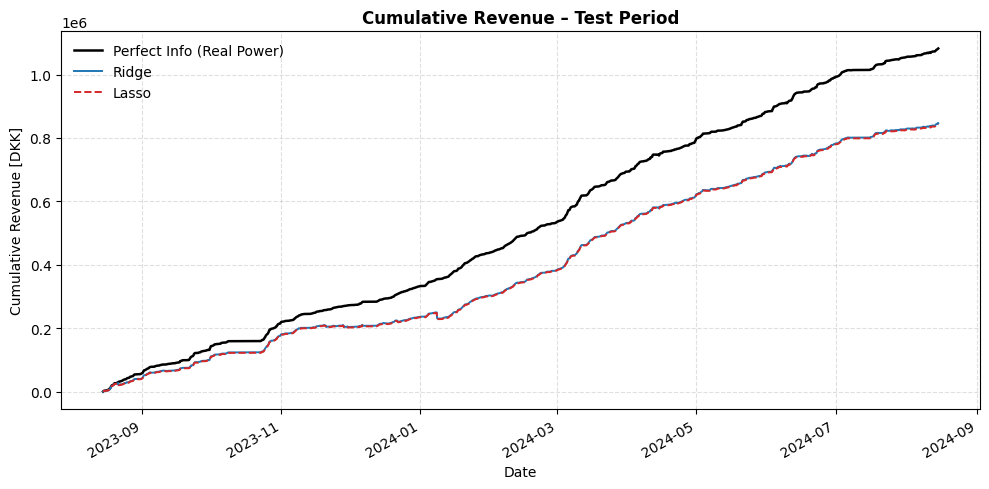

In [16]:
# --- Cumulative revenue over time for Test Period ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute instantaneous profits (hourly or timestep-based)
def profit_series(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    R_D = price_da * p_commit
    R_B = price_down * imbalance_pos - price_up * imbalance_neg
    return R_D + R_B  # array of profit per timestep

# Compute series for each model
profit_real_ts  = profit_series(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_ridge_ts = profit_series(y_pred_ridge_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_lasso_ts = profit_series(y_pred_lasso_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

# Build DataFrame for plotting
rev_df = pd.DataFrame({
    "Date": test_df["ts"],
    "Perfect Info": np.cumsum(profit_real_ts),
    "Ridge": np.cumsum(profit_ridge_ts),
    "Lasso": np.cumsum(profit_lasso_ts)
})

plt.figure(figsize=(10,5))
plt.plot(rev_df["Date"], rev_df["Perfect Info"], color="black", lw=1.8, label="Perfect Info (Real Power)")
plt.plot(rev_df["Date"], rev_df["Ridge"], color="#1f77b4", lw=1.4, label="Ridge")
plt.plot(rev_df["Date"], rev_df["Lasso"], color="#d62728", lw=1.4, linestyle="--", label="Lasso")

plt.title("Cumulative Revenue – Test Period", fontsize=12, weight='bold')
plt.xlabel("Date")
plt.ylabel("Cumulative Revenue [DKK]")
plt.legend(frameon=False)
plt.grid(alpha=0.4, linestyle='--')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


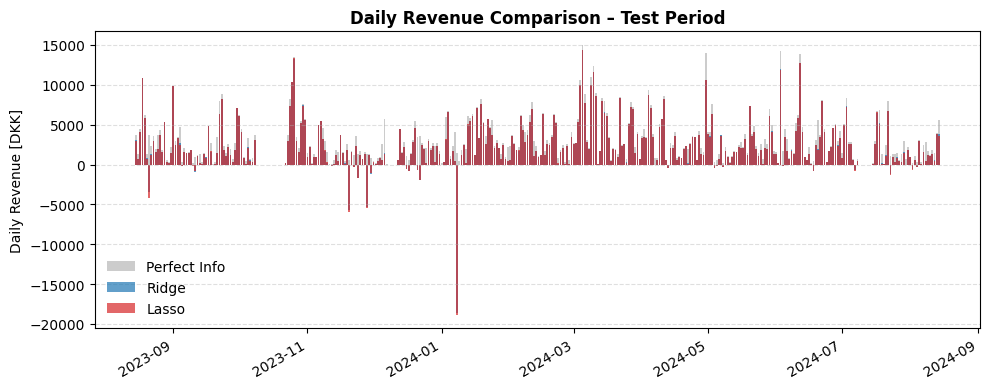

In [17]:
# --- Daily total revenue (bar chart) ---
rev_daily = pd.DataFrame({
    "Date": test_df["ts"].dt.date,
    "Perfect Info": profit_real_ts,
    "Ridge": profit_ridge_ts,
    "Lasso": profit_lasso_ts
}).groupby("Date").sum().reset_index()

plt.figure(figsize=(10,4))
plt.bar(rev_daily["Date"], rev_daily["Perfect Info"], color="gray", alpha=0.4, label="Perfect Info")
plt.bar(rev_daily["Date"], rev_daily["Ridge"], color="#1f77b4", alpha=0.7, label="Ridge")
plt.bar(rev_daily["Date"], rev_daily["Lasso"], color="#d62728", alpha=0.7, label="Lasso")
plt.title("Daily Revenue Comparison – Test Period", fontsize=12, weight='bold')
plt.ylabel("Daily Revenue [DKK]")
plt.legend(frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


In [18]:
test_results = {
    "model_name": "Regularized Ridge",
    "y_test": p_real_test,
    "y_test_pred": y_test_pred_ridge,
    "test_rmse": test_rmse,
}

In [19]:
# --- Export Results for Regularized Ridge ---
import pandas as pd, os

os.makedirs("Results", exist_ok=True)

# Save full test predictions
pd.DataFrame({
    "ts": test_df["ts"],
    "y_test": test_results["y_test"],
    "y_pred": test_results["y_test_pred"]
}).to_csv("Results/regularized_ridge_predictions.csv", index=False)

# Save summary metrics
pd.DataFrame([{
    "model": test_results["model_name"],
    "test_rmse": float(test_results["test_rmse"])
}]).to_csv("Results/regularized_ridge_summary.csv", index=False)

print("✅ Exported Regularized Ridge results to 'Results/' folder.")


✅ Exported Regularized Ridge results to 'Results/' folder.
